# 모델링(무시하셈)

## 1

In [4]:
import pandas as pd

# train = pd.read_csv(r'C:/Users/DC/OneDrive - 계명대학교/DC/2024/2024_날씨빅콘/데셋/train_fi.csv')
test = pd.read_csv(r'C:/Users/DC/OneDrive - 계명대학교/DC/2024/2024_날씨빅콘/데셋/test_fi.csv')

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593181 entries, 0 to 7593180
Data columns (total 93 columns):
 #   Column         Dtype  
---  ------         -----  
 0   격자넘버           int64  
 1   시간             int64  
 2   지점번호           int64  
 3   기온             float64
 4   상대습도           float64
 5   풍속             float64
 6   강수량            float64
 7   체감온도           float64
 8   요일             int64  
 9   주중주말           int64  
 10  전력기상지수         float64
 11  계절             object 
 12  년              int64  
 13  월              int64  
 14  일              int64  
 15  기온_mean_num    float64
 16  기온_std_num     float64
 17  기온_skew_num    float64
 18  상대습도_mean_num  float64
 19  상대습도_std_num   float64
 20  상대습도_skew_num  float64
 21  풍속_mean_num    float64
 22  풍속_std_num     float64
 23  풍속_skew_num    float64
 24  강수량_mean_num   float64
 25  강수량_std_num    float64
 26  강수량_skew_num   float64
 27  체감온도_mean_num  float64
 28  체감온도_std_num   float64
 29  체감온도_skew_num 

In [3]:
object_columns = train.select_dtypes(include=['object']).columns
print("Object 타입의 열:", object_columns)
train = pd.get_dummies(train, columns=object_columns)

Object 타입의 열: Index(['계절'], dtype='object')


In [9]:
# boolean 값을 정수형으로 변환
train = train.astype(float)

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838143 entries, 0 to 2838142
Data columns (total 92 columns):
 #   Column         Dtype  
---  ------         -----  
 0   격자넘버           int64  
 1   시간             int64  
 2   지점번호           int64  
 3   기온             float64
 4   상대습도           float64
 5   풍속             float64
 6   강수량            float64
 7   체감온도           float64
 8   요일             int64  
 9   주중주말           int64  
 10  계절             object 
 11  년              int64  
 12  월              int64  
 13  일              int64  
 14  기온_mean_num    float64
 15  기온_std_num     float64
 16  기온_skew_num    float64
 17  상대습도_mean_num  float64
 18  상대습도_std_num   float64
 19  상대습도_skew_num  float64
 20  풍속_mean_num    float64
 21  풍속_std_num     float64
 22  풍속_skew_num    float64
 23  강수량_mean_num   float64
 24  강수량_std_num    float64
 25  강수량_skew_num   float64
 26  체감온도_mean_num  float64
 27  체감온도_std_num   float64
 28  체감온도_skew_num  float64
 29  기온_mean_bn    

## 2

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# train 데이터프레임이 이미 정의되어 있어야 합니다.
# 예시: train = pd.read_csv('train.csv')

X = train.drop('전력기상지수', axis=1)
y = train['전력기상지수']

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 목표 변수 numpy array로 변환 후 reshape
y_train_np = y_train.values.reshape(-1, 1)
y_val_np = y_val.values.reshape(-1, 1)

# TabNet 모델 생성
tabnet = TabNetRegressor()

# 랜덤 서치 파라미터 설정
param_dist = {
    'n_d': [8, 16, 24, 32, 64],
    'n_a': [8, 16, 24, 32, 64],
    'n_steps': [3, 5, 7, 9, 11],
    'gamma': [1.0, 1.5, 2.0, 2.5],
    'lambda_sparse': [0, 1e-4, 1e-3, 1e-2]
}

# 데이터 numpy array로 변환
X_train_np = X_train.values
X_val_np = X_val.values

# 랜덤 서치
random_search = RandomizedSearchCV(
    tabnet, 
    param_dist, 
    n_iter=20, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=1, 
    verbose=2, 
    random_state=42
)

# 조기 중지 설정을 포함하여 모델 학습
random_search.fit(X_train_np, y_train_np, 
                  max_epochs=200, 
                  patience=10, 
                  eval_metric=['rmse'], 
                  eval_set=[(X_val_np, y_val_np)])

print("Best parameters found by Random Search:", random_search.best_params_)
print("Best cross-validation MSE by Random Search:", -random_search.best_score_)

# 검증 데이터에 대한 예측
y_pred_random = random_search.predict(X_val_np)

# 평가 지표 계산
mae = mean_absolute_error(y_val_np, y_pred_random)
mse = mean_squared_error(y_val_np, y_pred_random)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_np, y_pred_random)

print("Validation MAE by Random Search:", mae)
print("Validation MSE by Random Search:", mse)
print("Validation RMSE by Random Search:", rmse)
print("Validation R² by Random Search:", r2)

# 랜덤 서치에서 최적의 파라미터 추출
best_params = random_search.best_params_


c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
epoch 0  | loss: 157.81074| val_0_rmse: 5.54347 |  0:04:56s
epoch 1  | loss: 32.94807| val_0_rmse: 5.36229 |  0:09:22s
epoch 2  | loss: 30.46575| val_0_rmse: 5.04574 |  0:13:49s
epoch 3  | loss: 28.62292| val_0_rmse: 5.00003 |  0:18:14s
epoch 4  | loss: 27.6523 | val_0_rmse: 5.18906 |  0:22:42s
epoch 5  | loss: 27.44149| val_0_rmse: 5.08769 |  0:27:08s
epoch 6  | loss: 27.35669| val_0_rmse: 4.93839 |  0:31:33s
epoch 7  | loss: 27.0736 | val_0_rmse: 4.85395 |  0:35:56s
epoch 8  | loss: 26.80343| val_0_rmse: 4.97945 |  0:40:19s
epoch 9  | loss: 26.50044| val_0_rmse: 4.92178 |  0:44:41s
epoch 10 | loss: 26.8736 | val_0_rmse: 4.85291 |  0:49:04s
epoch 11 | loss: 26.37037| val_0_rmse: 4.75167 |  0:53:26s
epoch 12 | loss: 26.21083| val_0_rmse: 4.88002 |  0:57:49s
epoch 13 | loss: 25.52691| val_0_rmse: 4.87282 |  1:02:11s
epoch 14 | loss: 25.19919| val_0_rmse: 4.94088 |  1:06:33s
epoch 15 | loss: 25.16069| val_0_rmse: 4.66147 |  1:

c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 210.43493| val_0_rmse: 6.98475 |  0:04:22s
epoch 1  | loss: 44.268  | val_0_rmse: 6.09675 |  0:08:45s
epoch 2  | loss: 35.42844| val_0_rmse: 5.75779 |  0:13:06s
epoch 3  | loss: 31.56798| val_0_rmse: 5.82487 |  0:17:28s
epoch 4  | loss: 29.9428 | val_0_rmse: 5.35753 |  0:21:50s
epoch 5  | loss: 29.79002| val_0_rmse: 5.19861 |  0:26:12s
epoch 6  | loss: 27.81145| val_0_rmse: 5.86507 |  0:30:34s
epoch 7  | loss: 28.08415| val_0_rmse: 4.86104 |  0:34:56s
epoch 8  | loss: 27.60313| val_0_rmse: 5.45555 |  0:39:18s
epoch 9  | loss: 26.96721| val_0_rmse: 5.11567 |  0:43:40s
epoch 10 | loss: 27.24981| val_0_rmse: 4.93857 |  0:48:01s
epoch 11 | loss: 26.73582| val_0_rmse: 12.53103|  0:52:24s
epoch 12 | loss: 26.49151| val_0_rmse: 5.77916 |  0:56:46s
epoch 13 | loss: 26.53871| val_0_rmse: 6.35827 |  1:01:08s
epoch 14 | loss: 26.26198| val_0_rmse: 7.52699 |  1:05:31s
epoch 15 | loss: 25.69684| val_0_rmse: 4.67852 |  1:09:55s
epoch 16 | loss: 27.29192| val_0_rmse: 6.61807 |  1:14:

KeyboardInterrupt: 

In [6]:
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import GridSearchCV
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 데이터 준비 (train 데이터프레임이 이미 정의되어 있어야 합니다)
# 예시: train = pd.read_csv('train.csv')
X = train.drop('전력기상지수', axis=1)
y = train['전력기상지수']

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# numpy 배열로 변환
y_train_np = y_train.values.reshape(-1, 1)
y_val_np = y_val.values.reshape(-1, 1)
X_train_np = X_train.values
X_val_np = X_val.values

# 그리드 서치 파라미터 설정 (범위를 좁혀서)
param_grid = {
    'n_d': [8],  # 범위 좁힘
    'n_a': [8],  # 범위 좁힘
    'n_steps': [4],  # 범위 좁힘
    'gamma': [1.8, 2.0],  # 범위 좁힘
    'lambda_sparse': [0.0001, 0.001]  # 범위 좁힘
}

# TabNet 모델 생성 (새로운 객체로)
tabnet = TabNetRegressor()

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=tabnet, 
    param_grid=param_grid, 
    cv=3, 
    scoring='neg_mean_squared_error',
    n_jobs=1,  # 가능한 모든 프로세서를 사용
    verbose=2
)

# 조기 중지 설정을 포함하여 모델 학습
grid_search.fit(X_train_np, y_train_np, 
                max_epochs=30,  # 최대 에포크 수를 줄임
                patience=5, 
                eval_metric=['rmse'], 
                eval_set=[(X_val_np, y_val_np)])

print("Best parameters found by Grid Search:", grid_search.best_params_)
print("Best cross-validation MSE by Grid Search:", -grid_search.best_score_)

# 검증 데이터에 대한 예측
y_pred_grid = grid_search.predict(X_val_np)

# 평가 지표 계산
mae = mean_absolute_error(y_val_np, y_pred_grid)
mse = mean_squared_error(y_val_np, y_pred_grid)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_np, y_pred_grid)

print("Validation MAE by Grid Search:", mae)
print("Validation MSE by Grid Search:", mse)
print("Validation RMSE by Grid Search:", rmse)
print("Validation R² by Grid Search:", r2)

c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


epoch 0  | loss: 178.59372| val_0_rmse: 7.00075 |  0:03:22s
epoch 1  | loss: 43.05306| val_0_rmse: 6.5761  |  0:06:40s
epoch 2  | loss: 36.88758| val_0_rmse: 6.31536 |  0:09:53s
epoch 3  | loss: 34.54943| val_0_rmse: 5.70431 |  0:13:05s
epoch 4  | loss: 35.51806| val_0_rmse: 5.75979 |  0:16:16s
epoch 5  | loss: 33.83595| val_0_rmse: 5.56334 |  0:19:27s
epoch 6  | loss: 32.72221| val_0_rmse: 5.6095  |  0:22:39s
epoch 7  | loss: 32.39753| val_0_rmse: 5.41635 |  0:25:52s
epoch 8  | loss: 32.08882| val_0_rmse: 5.16174 |  0:29:03s
epoch 9  | loss: 30.54395| val_0_rmse: 5.23892 |  0:32:15s
epoch 10 | loss: 29.56623| val_0_rmse: 5.28964 |  0:35:26s
epoch 11 | loss: 29.59462| val_0_rmse: 5.91515 |  0:38:37s
epoch 12 | loss: 29.66732| val_0_rmse: 5.57093 |  0:41:49s
epoch 13 | loss: 29.10019| val_0_rmse: 5.35448 |  0:45:01s

Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_rmse = 5.16174
[CV] END gamma=1.8, lambda_sparse=0.0001, n_a=8, n_d=8, n_steps=4; total time=45.6min


c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 169.73413| val_0_rmse: 5.72258 |  0:03:13s
epoch 1  | loss: 36.08628| val_0_rmse: 5.8792  |  0:06:26s
epoch 2  | loss: 32.11274| val_0_rmse: 5.20068 |  0:09:39s
epoch 3  | loss: 30.37441| val_0_rmse: 5.04943 |  0:12:52s
epoch 4  | loss: 29.26138| val_0_rmse: 4.98788 |  0:16:05s
epoch 5  | loss: 28.71488| val_0_rmse: 4.97945 |  0:19:18s
epoch 6  | loss: 27.96233| val_0_rmse: 5.10107 |  0:22:32s
epoch 7  | loss: 27.4189 | val_0_rmse: 5.33059 |  0:25:46s
epoch 8  | loss: 27.03511| val_0_rmse: 4.87643 |  0:29:02s
epoch 9  | loss: 26.60256| val_0_rmse: 5.46678 |  0:32:18s
epoch 10 | loss: 27.04553| val_0_rmse: 5.18455 |  0:35:33s
epoch 11 | loss: 26.34109| val_0_rmse: 4.86041 |  0:38:47s
epoch 12 | loss: 25.94653| val_0_rmse: 4.80381 |  0:42:01s
epoch 13 | loss: 25.79829| val_0_rmse: 4.94285 |  0:45:15s
epoch 14 | loss: 25.55814| val_0_rmse: 4.727   |  0:48:28s
epoch 15 | loss: 25.39684| val_0_rmse: 4.86984 |  0:51:42s
epoch 16 | loss: 25.39279| val_0_rmse: 8.40432 |  0:54:

c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 172.41578| val_0_rmse: 5.85274 |  0:03:14s
epoch 1  | loss: 40.54939| val_0_rmse: 5.7794  |  0:06:28s
epoch 2  | loss: 35.68308| val_0_rmse: 5.39604 |  0:09:42s
epoch 3  | loss: 33.05087| val_0_rmse: 5.22857 |  0:12:56s
epoch 4  | loss: 31.84439| val_0_rmse: 5.32249 |  0:16:09s
epoch 5  | loss: 30.99674| val_0_rmse: 5.1349  |  0:19:26s
epoch 6  | loss: 29.93673| val_0_rmse: 5.19153 |  0:22:39s
epoch 7  | loss: 29.41677| val_0_rmse: 5.08995 |  0:25:51s
epoch 8  | loss: 28.89429| val_0_rmse: 4.94934 |  0:29:04s
epoch 9  | loss: 28.5854 | val_0_rmse: 5.10586 |  0:32:18s
epoch 10 | loss: 28.73862| val_0_rmse: 5.2538  |  0:35:30s
epoch 11 | loss: 28.07037| val_0_rmse: 5.29502 |  0:38:43s
epoch 12 | loss: 27.89264| val_0_rmse: 4.92431 |  0:41:57s
epoch 13 | loss: 27.46484| val_0_rmse: 5.22949 |  0:45:10s
epoch 14 | loss: 27.19005| val_0_rmse: 4.83775 |  0:48:25s
epoch 15 | loss: 27.21597| val_0_rmse: 4.85994 |  0:51:42s
epoch 16 | loss: 26.96217| val_0_rmse: 4.92107 |  0:55:

c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 164.67378| val_0_rmse: 5.57471 |  0:03:12s
epoch 1  | loss: 35.40491| val_0_rmse: 5.79712 |  0:06:25s
epoch 2  | loss: 31.84667| val_0_rmse: 5.23469 |  0:09:38s
epoch 3  | loss: 30.08286| val_0_rmse: 5.08061 |  0:12:51s
epoch 4  | loss: 28.81296| val_0_rmse: 5.15911 |  0:16:04s
epoch 5  | loss: 28.01098| val_0_rmse: 5.02216 |  0:19:18s
epoch 6  | loss: 27.23171| val_0_rmse: 4.9914  |  0:22:31s
epoch 7  | loss: 26.68517| val_0_rmse: 5.13837 |  0:25:44s
epoch 8  | loss: 26.3741 | val_0_rmse: 4.85928 |  0:28:57s
epoch 9  | loss: 26.00466| val_0_rmse: 5.05544 |  0:32:09s
epoch 10 | loss: 26.04084| val_0_rmse: 4.9691  |  0:35:23s
epoch 11 | loss: 25.61984| val_0_rmse: 5.48509 |  0:38:35s
epoch 12 | loss: 25.42026| val_0_rmse: 5.80258 |  0:41:47s
epoch 13 | loss: 25.26055| val_0_rmse: 4.94545 |  0:45:00s

Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_rmse = 4.85928
[CV] END gamma=1.8, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=4; total time=45.5min


c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 165.51466| val_0_rmse: 5.41685 |  0:03:13s
epoch 1  | loss: 32.96113| val_0_rmse: 5.44257 |  0:06:26s
epoch 2  | loss: 30.26938| val_0_rmse: 5.33641 |  0:09:38s
epoch 3  | loss: 28.8091 | val_0_rmse: 5.12041 |  0:12:52s
epoch 4  | loss: 28.3546 | val_0_rmse: 5.03088 |  0:16:05s
epoch 5  | loss: 27.47307| val_0_rmse: 4.97803 |  0:19:18s
epoch 6  | loss: 27.0777 | val_0_rmse: 4.94156 |  0:22:31s
epoch 7  | loss: 26.61705| val_0_rmse: 4.87773 |  0:25:46s
epoch 8  | loss: 26.37084| val_0_rmse: 4.95152 |  0:28:59s
epoch 9  | loss: 25.99396| val_0_rmse: 4.81634 |  0:32:13s
epoch 10 | loss: 25.92387| val_0_rmse: 5.01851 |  0:35:26s
epoch 11 | loss: 25.55316| val_0_rmse: 4.82515 |  0:38:40s
epoch 12 | loss: 25.73013| val_0_rmse: 4.80854 |  0:41:53s
epoch 13 | loss: 25.33456| val_0_rmse: 4.73716 |  0:45:06s
epoch 14 | loss: 25.18675| val_0_rmse: 4.73699 |  0:48:20s
epoch 15 | loss: 24.72661| val_0_rmse: 5.55204 |  0:51:33s
epoch 16 | loss: 24.89383| val_0_rmse: 4.85442 |  0:54:

c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 170.08176| val_0_rmse: 5.87679 |  0:03:13s
epoch 1  | loss: 34.95658| val_0_rmse: 5.50333 |  0:06:26s
epoch 2  | loss: 31.56354| val_0_rmse: 5.12102 |  0:09:38s
epoch 3  | loss: 29.68325| val_0_rmse: 5.05456 |  0:12:51s
epoch 4  | loss: 28.71626| val_0_rmse: 4.9785  |  0:16:04s
epoch 5  | loss: 27.89781| val_0_rmse: 4.99712 |  0:19:18s
epoch 6  | loss: 27.33984| val_0_rmse: 4.89244 |  0:22:34s
epoch 7  | loss: 27.23834| val_0_rmse: 4.90843 |  0:25:48s
epoch 8  | loss: 26.64229| val_0_rmse: 4.79239 |  0:29:05s
epoch 9  | loss: 26.24368| val_0_rmse: 5.20057 |  0:32:19s
epoch 10 | loss: 25.95345| val_0_rmse: 4.73752 |  0:35:33s
epoch 11 | loss: 25.74519| val_0_rmse: 5.20648 |  0:38:47s
epoch 12 | loss: 25.61863| val_0_rmse: 5.80089 |  0:42:01s
epoch 13 | loss: 25.60446| val_0_rmse: 4.66851 |  0:45:15s
epoch 14 | loss: 25.34043| val_0_rmse: 5.11816 |  0:48:29s
epoch 15 | loss: 25.22958| val_0_rmse: 5.30434 |  0:51:42s
epoch 16 | loss: 24.98236| val_0_rmse: 4.79592 |  0:54:

c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 173.35832| val_0_rmse: 6.00569 |  0:03:13s
epoch 1  | loss: 37.90009| val_0_rmse: 5.99259 |  0:06:27s
epoch 2  | loss: 33.42831| val_0_rmse: 5.42925 |  0:09:41s
epoch 3  | loss: 32.27217| val_0_rmse: 5.13414 |  0:12:56s
epoch 4  | loss: 30.753  | val_0_rmse: 5.47307 |  0:16:10s
epoch 5  | loss: 30.60588| val_0_rmse: 5.10349 |  0:19:24s
epoch 6  | loss: 29.68492| val_0_rmse: 5.25938 |  0:22:38s
epoch 7  | loss: 29.21127| val_0_rmse: 4.98041 |  0:25:52s
epoch 8  | loss: 29.5737 | val_0_rmse: 4.92386 |  0:29:07s
epoch 9  | loss: 28.58455| val_0_rmse: 5.10433 |  0:32:21s
epoch 10 | loss: 27.89667| val_0_rmse: 5.65346 |  0:35:36s
epoch 11 | loss: 27.82982| val_0_rmse: 5.6822  |  0:38:50s
epoch 12 | loss: 27.79338| val_0_rmse: 5.24362 |  0:42:04s
epoch 13 | loss: 27.58649| val_0_rmse: 4.80894 |  0:45:18s
epoch 14 | loss: 27.27019| val_0_rmse: 5.0109  |  0:48:32s
epoch 15 | loss: 26.81836| val_0_rmse: 4.95715 |  0:51:47s
epoch 16 | loss: 27.01607| val_0_rmse: 4.95223 |  0:55:

c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 184.52376| val_0_rmse: 5.65431 |  0:03:14s
epoch 1  | loss: 34.99884| val_0_rmse: 5.47675 |  0:06:28s
epoch 2  | loss: 32.22398| val_0_rmse: 5.19164 |  0:09:43s
epoch 3  | loss: 30.60436| val_0_rmse: 5.12247 |  0:12:57s
epoch 4  | loss: 29.33378| val_0_rmse: 5.14475 |  0:16:12s
epoch 5  | loss: 30.59069| val_0_rmse: 5.06578 |  0:19:28s
epoch 6  | loss: 29.72388| val_0_rmse: 10.09958|  0:22:43s
epoch 7  | loss: 29.52606| val_0_rmse: 5.11197 |  0:25:58s
epoch 8  | loss: 28.87589| val_0_rmse: 4.9201  |  0:29:13s
epoch 9  | loss: 27.65593| val_0_rmse: 4.92922 |  0:32:27s
epoch 10 | loss: 26.77429| val_0_rmse: 4.8635  |  0:35:42s
epoch 11 | loss: 26.43027| val_0_rmse: 4.9394  |  0:38:55s
epoch 12 | loss: 27.03408| val_0_rmse: 4.8024  |  0:42:10s
epoch 13 | loss: 27.15572| val_0_rmse: 5.07668 |  0:45:24s
epoch 14 | loss: 26.60598| val_0_rmse: 5.00291 |  0:48:38s
epoch 15 | loss: 26.16802| val_0_rmse: 4.79481 |  0:51:53s
epoch 16 | loss: 25.7276 | val_0_rmse: 4.86686 |  0:55:

c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 176.48232| val_0_rmse: 5.81923 |  0:03:14s
epoch 1  | loss: 36.75649| val_0_rmse: 5.30334 |  0:06:29s
epoch 2  | loss: 32.47313| val_0_rmse: 5.14554 |  0:09:44s
epoch 3  | loss: 30.32817| val_0_rmse: 5.42769 |  0:12:58s
epoch 4  | loss: 29.27796| val_0_rmse: 5.06991 |  0:16:13s
epoch 5  | loss: 28.48669| val_0_rmse: 5.0925  |  0:19:27s
epoch 6  | loss: 27.97495| val_0_rmse: 4.83621 |  0:22:41s
epoch 7  | loss: 27.4486 | val_0_rmse: 5.037   |  0:25:55s
epoch 8  | loss: 26.95224| val_0_rmse: 4.88382 |  0:29:08s
epoch 9  | loss: 26.75659| val_0_rmse: 4.85651 |  0:32:22s
epoch 10 | loss: 26.51973| val_0_rmse: 5.00924 |  0:35:36s
epoch 11 | loss: 26.18286| val_0_rmse: 4.85744 |  0:38:50s

Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_rmse = 4.83621
[CV] END gamma=2.0, lambda_sparse=0.0001, n_a=8, n_d=8, n_steps=4; total time=39.3min


c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 174.79991| val_0_rmse: 5.96452 |  0:03:13s
epoch 1  | loss: 36.47073| val_0_rmse: 5.5223  |  0:06:27s
epoch 2  | loss: 32.812  | val_0_rmse: 5.68049 |  0:09:40s
epoch 3  | loss: 30.60224| val_0_rmse: 5.41939 |  0:12:54s
epoch 4  | loss: 29.05183| val_0_rmse: 5.15843 |  0:16:08s
epoch 5  | loss: 28.35683| val_0_rmse: 4.91803 |  0:19:22s
epoch 6  | loss: 27.60014| val_0_rmse: 6.5804  |  0:22:36s
epoch 7  | loss: 27.1669 | val_0_rmse: 11.17288|  0:25:51s
epoch 8  | loss: 26.74896| val_0_rmse: 5.25218 |  0:29:05s
epoch 9  | loss: 26.33217| val_0_rmse: 5.19999 |  0:32:18s
epoch 10 | loss: 26.08863| val_0_rmse: 5.11654 |  0:35:32s

Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_rmse = 4.91803
[CV] END gamma=2.0, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=4; total time=36.0min


c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 159.60835| val_0_rmse: 5.55581 |  0:03:13s
epoch 1  | loss: 33.55218| val_0_rmse: 5.88878 |  0:06:26s
epoch 2  | loss: 30.5149 | val_0_rmse: 5.01947 |  0:09:41s
epoch 3  | loss: 28.95689| val_0_rmse: 5.38615 |  0:12:57s
epoch 4  | loss: 28.15463| val_0_rmse: 5.39253 |  0:16:10s
epoch 5  | loss: 27.55531| val_0_rmse: 4.83583 |  0:19:24s
epoch 6  | loss: 27.09008| val_0_rmse: 4.91575 |  0:22:39s
epoch 7  | loss: 26.72773| val_0_rmse: 4.95246 |  0:25:54s
epoch 8  | loss: 26.59884| val_0_rmse: 5.20878 |  0:29:08s
epoch 9  | loss: 27.00454| val_0_rmse: 5.1478  |  0:32:21s
epoch 10 | loss: 26.26479| val_0_rmse: 4.79957 |  0:35:35s
epoch 11 | loss: 25.52383| val_0_rmse: 4.72539 |  0:38:49s
epoch 12 | loss: 25.15853| val_0_rmse: 4.71981 |  0:42:04s
epoch 13 | loss: 24.92474| val_0_rmse: 4.80055 |  0:45:16s
epoch 14 | loss: 26.76759| val_0_rmse: 4.67992 |  0:48:30s
epoch 15 | loss: 26.28889| val_0_rmse: 5.21331 |  0:51:44s
epoch 16 | loss: 25.25662| val_0_rmse: 4.74106 |  0:54:

c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 166.00718| val_0_rmse: 5.66829 |  0:03:13s
epoch 1  | loss: 35.01276| val_0_rmse: 5.55814 |  0:06:27s
epoch 2  | loss: 31.24336| val_0_rmse: 5.26052 |  0:09:40s
epoch 3  | loss: 29.43727| val_0_rmse: 5.20063 |  0:12:54s
epoch 4  | loss: 28.30453| val_0_rmse: 5.1571  |  0:16:08s
epoch 5  | loss: 27.751  | val_0_rmse: 4.97945 |  0:19:21s
epoch 6  | loss: 27.15114| val_0_rmse: 4.96472 |  0:22:37s
epoch 7  | loss: 26.64624| val_0_rmse: 6.07173 |  0:25:52s
epoch 8  | loss: 26.36044| val_0_rmse: 5.32476 |  0:29:07s
epoch 9  | loss: 26.03431| val_0_rmse: 7.34531 |  0:32:21s
epoch 10 | loss: 25.80265| val_0_rmse: 5.29645 |  0:35:36s
epoch 11 | loss: 25.50959| val_0_rmse: 7.89704 |  0:38:51s

Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_rmse = 4.96472
[CV] END gamma=2.0, lambda_sparse=0.001, n_a=8, n_d=8, n_steps=4; total time=39.3min


c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


ValueError: 
All the 12 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py", line 278, in fit
    self.feature_importances_ = self._compute_feature_importances(X_train)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py", line 759, in _compute_feature_importances
    M_explain, _ = self.explain(X, normalize=False)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py", line 353, in explain
    for batch_nb, data in enumerate(dataloader):
  File "c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py", line 631, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py", line 675, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 54, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\_utils\collate.py", line 277, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\_utils\collate.py", line 121, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\_utils\collate.py", line 181, in collate_numpy_array_fn
    raise TypeError(default_collate_err_msg_format.format(elem.dtype))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found object


## 3

In [18]:
import torch
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor
import joblib

# 데이터 준비
X = train.drop('전력기상지수', axis=1)
y = train['전력기상지수']

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 목표 변수 numpy array로 변환 후 reshape
y_train_np = y_train.values.reshape(-1, 1)
y_val_np = y_val.values.reshape(-1, 1)

# 데이터 numpy array로 변환
X_train_np = X_train.values
X_val_np = X_val.values

# 데이터 타입과 모양 확인
print(type(X_train_np), X_train_np.shape)
print(type(y_train_np), y_train_np.shape)
print(type(X_val_np), X_val_np.shape)
print(type(y_val_np), y_val_np.shape)


# 하이퍼파라미터 설정
params = {
    'n_d': 8,
    'n_a': 8,
    'n_steps': 4,
    'gamma': 2.0,
    'lambda_sparse': 0.001
}

# TabNet Regressor 모델 정의 및 설정
model = TabNetRegressor(**params)

# 모델 학습
model.fit(
    X_train_np, y_train_np,
    max_epochs=7,  # 최대 에포크 수를 줄임
    patience=2, 
    eval_metric=['rmse'], 
    eval_set=[(X_val_np, y_val_np)]
)

<class 'numpy.ndarray'> (6074544, 95)
<class 'numpy.ndarray'> (6074544, 1)
<class 'numpy.ndarray'> (1518637, 95)
<class 'numpy.ndarray'> (1518637, 1)


c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 127.36815| val_0_rmse: 5.78054 |  0:04:35s
epoch 1  | loss: 34.25357| val_0_rmse: 5.8888  |  0:09:06s
epoch 2  | loss: 30.92995| val_0_rmse: 5.10062 |  0:13:38s
epoch 3  | loss: 29.65534| val_0_rmse: 5.21534 |  0:18:11s
epoch 4  | loss: 28.84016| val_0_rmse: 5.03884 |  0:22:43s
epoch 5  | loss: 28.03538| val_0_rmse: 4.74181 |  0:27:15s
epoch 6  | loss: 27.43432| val_0_rmse: 4.92455 |  0:31:48s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_rmse = 4.74181


c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


KeyboardInterrupt: 

## 4

In [2]:
# model.save_model('best_tabnet_model')

# print(f"Best model saved to 'best_tabnet_model.zip'")
from pytorch_tabnet.tab_model import TabNetRegressor
# 최적 모델 로드 및 검증 데이터로 예측 수행
loaded_model = TabNetRegressor()
loaded_model.load_model(r'C:/Users/DC/OneDrive - 계명대학교/DC/2024/2024_날씨빅콘/코드/best_tabnet_model.zip')

c:\Users\DC\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [5]:
object_columns = test.select_dtypes(include=['object']).columns
print("Object 타입의 열:", object_columns)
test = pd.get_dummies(test, columns=object_columns)

Object 타입의 열: Index(['계절'], dtype='object')


In [6]:
# boolean 값을 정수형으로 변환
test = test.astype(float)

In [7]:
import numpy as np

X_test_np = test.values

# 최종 모델을 사용하여 test 데이터셋에 대한 예측 수행
y_test_pred = loaded_model.predict(X_test_np)

In [8]:
df = pd.read_csv(r'C:/Users/DC/OneDrive - 계명대학교/DC/2024/2024_날씨빅콘/제출데셋/electric_test.csv')

In [41]:
# def remove_nan(df, nan_value=-99):
#     for column in df.columns:
#         df = df[df[column] != nan_value]
#     return df


# df = remove_nan(df)

In [9]:
n_test = len(df)
n_pred = len(y_test_pred)

if n_test != n_pred:
    # 예측값 길이와 데이터프레임 길이 차이 계산
    diff = n_test - n_pred
    
    # 앞뒤 평균으로 채울 값을 생성
    y_test_pred_extended = list(y_test_pred)
    
    for i in range(diff):
        # 앞뒤 평균으로 결측값을 채움
        if i == 0:
            # 처음에 추가할 경우
            y_test_pred_extended.insert(0, (y_test_pred_extended[0] + y_test_pred_extended[1]) / 2)
        else:
            # 그 외의 경우
            y_test_pred_extended.append((y_test_pred_extended[-1] + y_test_pred_extended[-2]) / 2)

    y_test_pred = np.array(y_test_pred_extended)

# 데이터프레임에 예측값 추가
df['elect'] = y_test_pred

In [10]:
df

,NUM,TM,HH24,STN,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elect
0,2385,2023-01-01 01:00:00,1,303,7.8,61.5,6.7,0.0,4.2,6,1.0,95.594788
1,2385,2023-01-01 02:00:00,2,303,7.9,60.6,7.6,0.0,4.0,6,1.0,95.450401
2,2385,2023-01-01 03:00:00,3,303,8.2,61.9,8.7,0.0,4.1,6,1.0,95.739174
3,2385,2023-01-01 04:00:00,4,303,8.4,60.9,9.2,0.0,4.3,6,1.0,99.930763
4,2385,2023-01-01 05:00:00,5,303,8.5,60.9,9.5,0.0,4.3,6,1.0,98.406364
...,...,...,...,...,...,...,...,...,...,...,...,...
2838234,12322,2023-12-31 19:00:00,19,901,5.7,72.3,3.6,0.0,5.7,6,1.0,101.669601
2838235,12322,2023-12-31 20:00:00,20,901,5.6,70.8,3.2,0.0,5.8,6,1.0,101.669601
2838236,12322,2023-12-31 21:00:00,21,901,5.3,69.1,3.6,0.0,4.5,6,1.0,101.669601
2838237,12322,2023-12-31 22:00:00,22,901,5.1,70.6,3.0,0.0,5.1,6,1.0,101.669601


In [11]:
df.to_csv(r'C:/Users/DC/OneDrive - 계명대학교/DC/2024/2024_날씨빅콘/제출데셋/240223.csv', index=False)

# 다중공산성 제거

In [12]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv(r'C:/Users/Owner/OneDrive - 계명대학교/DC/2024/2024_날씨빅콘/데셋/real_ele_tr.csv')
test = pd.read_csv(r'C:/Users/Owner/OneDrive - 계명대학교/DC/2024/2024_날씨빅콘/데셋/real_ele_te.csv')

In [3]:
train2 = train.drop(['electric_train.n', 'electric_train.sum_qctr','electric_train.sum_load','electric_train.n_mean_load'], axis=1)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593355 entries, 0 to 7593354
Data columns (total 16 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   electric_train.num          int64  
 1   electric_train.tm           object 
 2   electric_train.hh24         int64  
 3   electric_train.n            int64  
 4   electric_train.stn          int64  
 5   electric_train.sum_qctr     int64  
 6   electric_train.sum_load     float64
 7   electric_train.n_mean_load  float64
 8   electric_train.nph_ta       float64
 9   electric_train.nph_hm       float64
 10  electric_train.nph_ws_10m   float64
 11  electric_train.nph_rn_60m   float64
 12  electric_train.nph_ta_chi   float64
 13  electric_train.weekday      int64  
 14  electric_train.week_name    int64  
 15  electric_train.elec         float64
dtypes: float64(8), int64(7), object(1)
memory usage: 926.9+ MB


In [5]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593355 entries, 0 to 7593354
Data columns (total 12 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   electric_train.num         int64  
 1   electric_train.tm          object 
 2   electric_train.hh24        int64  
 3   electric_train.stn         int64  
 4   electric_train.nph_ta      float64
 5   electric_train.nph_hm      float64
 6   electric_train.nph_ws_10m  float64
 7   electric_train.nph_rn_60m  float64
 8   electric_train.nph_ta_chi  float64
 9   electric_train.weekday     int64  
 10  electric_train.week_name   int64  
 11  electric_train.elec        float64
dtypes: float64(6), int64(5), object(1)
memory usage: 695.2+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838239 entries, 0 to 2838238
Data columns (total 11 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   electric_test.num         int64  
 1   electric_test.tm          object 
 2   electric_test.hh24        int64  
 3   electric_test.stn         int64  
 4   electric_test.nph_ta      float64
 5   electric_test.nph_hm      float64
 6   electric_test.nph_ws_10m  float64
 7   electric_test.nph_rn_60m  float64
 8   electric_test.nph_ta_chi  float64
 9   electric_test.weekday     int64  
 10  electric_test.week_name   int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 238.2+ MB


-  기온과 체감온도 제거 필요 
-  격자는 왜,...?
-  상대습도도 생각

In [11]:
train3 = train2.drop('electric_train.elec', axis=1)

# object 타입을 제외한 숫자형 데이터만 사용
numeric_df = train3.select_dtypes(include=[np.number])

# VIF 계산
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_df.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]

print(vif_data)

                     feature        VIF
0         electric_train.num  11.037298
1        electric_train.hh24   4.084895
2         electric_train.stn   4.331200
3      electric_train.nph_ta  33.669368
4      electric_train.nph_hm  11.137389
5  electric_train.nph_ws_10m   2.242549
6  electric_train.nph_rn_60m   1.035974
7  electric_train.nph_ta_chi  25.333985
8     electric_train.weekday   8.355353
9   electric_train.week_name   3.675126


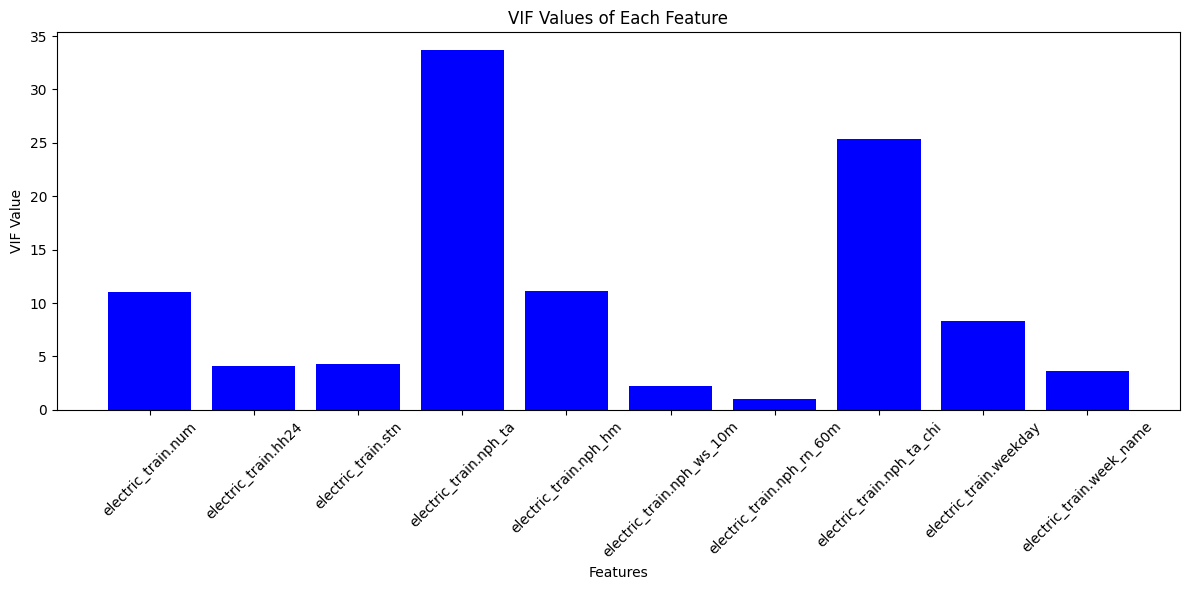

In [15]:
numeric_df = train3.select_dtypes(include=[np.number])

# VIF 계산
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_df.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]

# 막대 그래프로 VIF 값 시각화
plt.figure(figsize=(12, 6))
plt.bar(vif_data['feature'], vif_data['VIF'], color='blue')
plt.xlabel('Features')
plt.ylabel('VIF Value')
plt.title('VIF Values of Each Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- 체감온도 와 기온 둘 중 하나 제거 하거나 
- 기온 - 체감온도 해서 둘 차이 해서 본 다음 계수 찍어보기?
- 주중 주말은 두는게 ㄱㅊ을 거라 생각
- 불쾌지수는 기온과 습도를 이용하여 계산되는데 [불쾌지수=1.8x기온–0.55x(1–습도)x(1.8x기온–26)+32] ( https://www.nhimc.or.kr/ilsan_news/Hello_2018Summer/html/sub01_03.html )
- 높은 습도는 더위를 더 불쾌하게 느끼게 할 가능성 존재 -> 이를 반영한 새로운 체감온도 지수

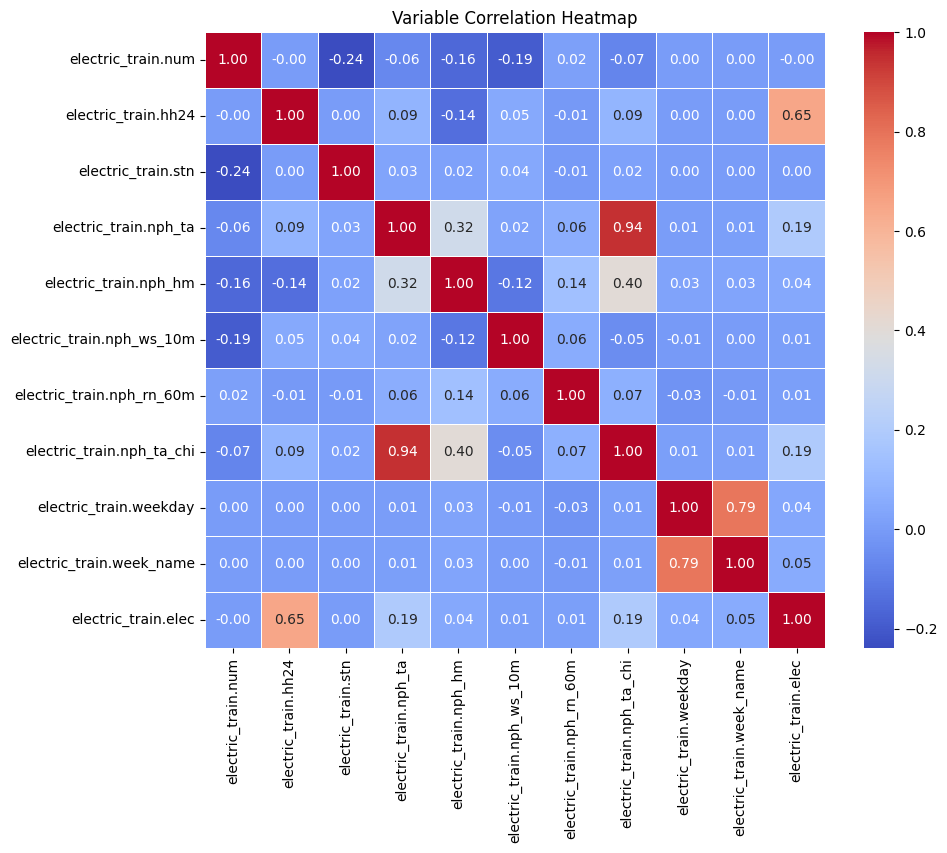

In [14]:
numeric_df = train2.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Variable Correlation Heatmap')
plt.show()